In [2]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import geopandas as gpd
import descartes

In [4]:
df = pd.read_csv("airline.csv")
print(df.head())
df.isna().sum()/len(df)


    airline_name                            link  \
0  adria-airways  /airline-reviews/adria-airways   
1  adria-airways  /airline-reviews/adria-airways   
2  adria-airways  /airline-reviews/adria-airways   
3  adria-airways  /airline-reviews/adria-airways   
4  adria-airways  /airline-reviews/adria-airways   

                           title        author author_country        date  \
0  Adria Airways customer review         D Ito        Germany  2015-04-10   
1  Adria Airways customer review  Ron Kuhlmann  United States  2015-01-05   
2  Adria Airways customer review       E Albin    Switzerland  2014-09-14   
3  Adria Airways customer review  Tercon Bojan      Singapore  2014-09-06   
4  Adria Airways customer review       L James         Poland  2014-06-16   

                                             content aircraft type_traveller  \
0  Outbound flight FRA/PRN A319. 2 hours 10 min f...      NaN            NaN   
1  Two short hops ZRH-LJU and LJU-VIE. Very fast ...      NaN   

airline_name                     0.000000
link                             0.000000
title                            0.000000
author                           0.000000
author_country                   0.038434
date                             0.000000
content                          0.000000
aircraft                         0.969127
type_traveller                   0.942555
cabin_flown                      0.069475
route                            0.943449
overall_rating                   0.109552
seat_comfort_rating              0.185767
cabin_staff_rating               0.185718
food_beverages_rating            0.196444
inflight_entertainment_rating    0.248381
ground_service_rating            0.946782
wifi_connectivity_rating         0.986351
value_money_rating               0.040415
recommended                      0.000000
dtype: float64

In [5]:
df.describe()
# Dropping irrelavant columns and columns with high proportion of NA values
df = df.drop(['link', 'title', 'author', 'aircraft', 'type_traveller', 'route', 'ground_service_rating'], axis=1)
df.head()

,airline_name,author_country,date,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,Economy,7.0,4.0,4.0,4.0,0.0,NaN,4.0,1
1,adria-airways,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,Business Class,10.0,4.0,5.0,4.0,1.0,NaN,5.0,1
2,adria-airways,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,Economy,9.0,5.0,5.0,4.0,0.0,NaN,5.0,1
3,adria-airways,Singapore,2014-09-06,Adria serves this 100 min flight from Ljubljan...,Business Class,8.0,4.0,4.0,3.0,1.0,NaN,4.0,1
4,adria-airways,Poland,2014-06-16,WAW-SKJ Economy. No free snacks or drinks on t...,Economy,4.0,4.0,2.0,1.0,2.0,NaN,2.0,0


In [6]:
# generate country code  based on country name 
import pycountry 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
df['CODE']=alpha3code(df.author_country)
df.head()

,airline_name,author_country,date,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,wifi_connectivity_rating,value_money_rating,recommended,CODE
0,adria-airways,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,Economy,7.0,4.0,4.0,4.0,0.0,NaN,4.0,1,DEU
1,adria-airways,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,Business Class,10.0,4.0,5.0,4.0,1.0,NaN,5.0,1,USA
2,adria-airways,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,Economy,9.0,5.0,5.0,4.0,0.0,NaN,5.0,1,CHE
3,adria-airways,Singapore,2014-09-06,Adria serves this 100 min flight from Ljubljan...,Business Class,8.0,4.0,4.0,3.0,1.0,NaN,4.0,1,SGP
4,adria-airways,Poland,2014-06-16,WAW-SKJ Economy. No free snacks or drinks on t...,Economy,4.0,4.0,2.0,1.0,2.0,NaN,2.0,0,POL


In [7]:
df['has_wifi'] = ~df['wifi_connectivity_rating'].isna()
df['has_wifi'] = df['has_wifi'].astype(int)
df['has_entertainment'] = ~df['inflight_entertainment_rating'].isna()
df['has_entertainment'] = df['has_entertainment'].astype(int)

print("Percentage of reviews that feature airlines with WiFi:",df['has_wifi'].value_counts(1).iloc[1]*100,"%")
print("Percentage of reviews that feature airlines with in-flight entertainment:",df['has_entertainment'].value_counts(1).iloc[0]*100,"%")

Percentage of reviews that feature airlines with WiFi: 1.3648661706445067 %
Percentage of reviews that feature airlines with in-flight entertainment: 75.16185138660741 %


In [8]:
df.has_wifi.value_counts()

0    40831
1      565
Name: has_wifi, dtype: int64

In [9]:
df.head()

,airline_name,author_country,date,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,wifi_connectivity_rating,value_money_rating,recommended,CODE,has_wifi,has_entertainment
0,adria-airways,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,Economy,7.0,4.0,4.0,4.0,0.0,NaN,4.0,1,DEU,0,1
1,adria-airways,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,Business Class,10.0,4.0,5.0,4.0,1.0,NaN,5.0,1,USA,0,1
2,adria-airways,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,Economy,9.0,5.0,5.0,4.0,0.0,NaN,5.0,1,CHE,0,1
3,adria-airways,Singapore,2014-09-06,Adria serves this 100 min flight from Ljubljan...,Business Class,8.0,4.0,4.0,3.0,1.0,NaN,4.0,1,SGP,0,1
4,adria-airways,Poland,2014-06-16,WAW-SKJ Economy. No free snacks or drinks on t...,Economy,4.0,4.0,2.0,1.0,2.0,NaN,2.0,0,POL,0,1


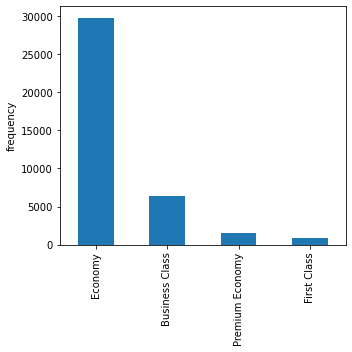

In [10]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

df['cabin_flown'].value_counts().plot(ax=ax, kind='bar', ylabel='frequency')

plt.show()

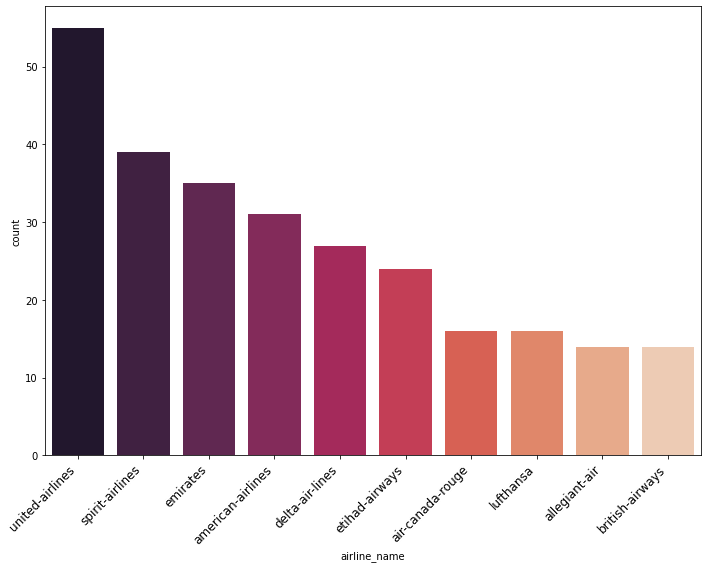

In [14]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="airline_name", data=df[df['has_wifi'] == 1], order=df['airline_name'][df['has_wifi'] == 1].value_counts().iloc[:10].index, palette='rocket')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'
)
plt.show()

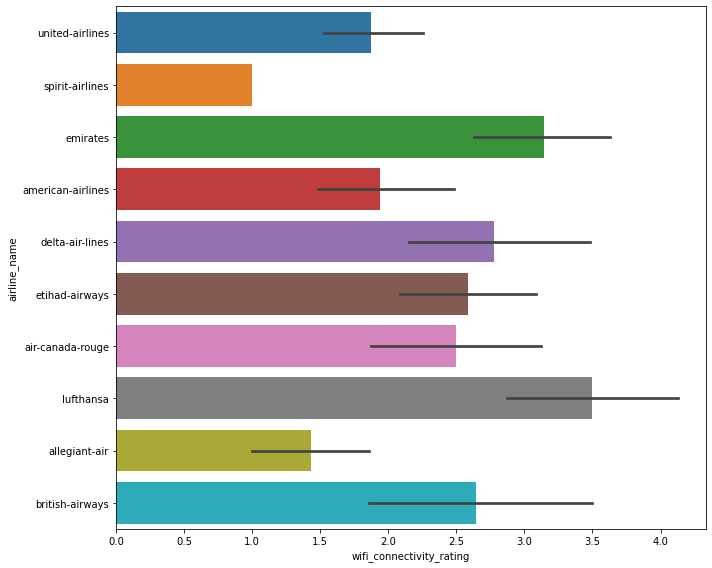

In [15]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x="wifi_connectivity_rating", y="airline_name", data=df[df['has_wifi'] == 1], order=df['airline_name'][df['has_wifi'] == 1].value_counts().iloc[:10].index)
# Lufthansa has the best Wifi connectivity rating with 3.5 score out of 5 and next is Emirates with a rating just greater than 3/5. 

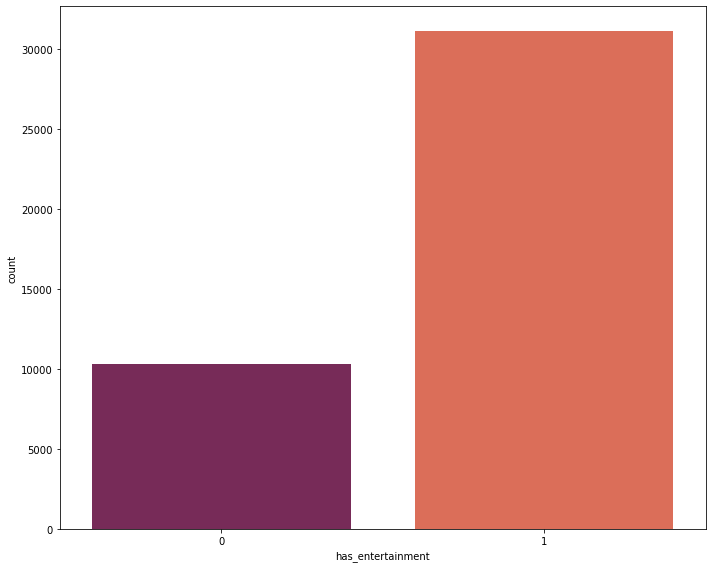

In [16]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="has_entertainment", data=df, palette='rocket')

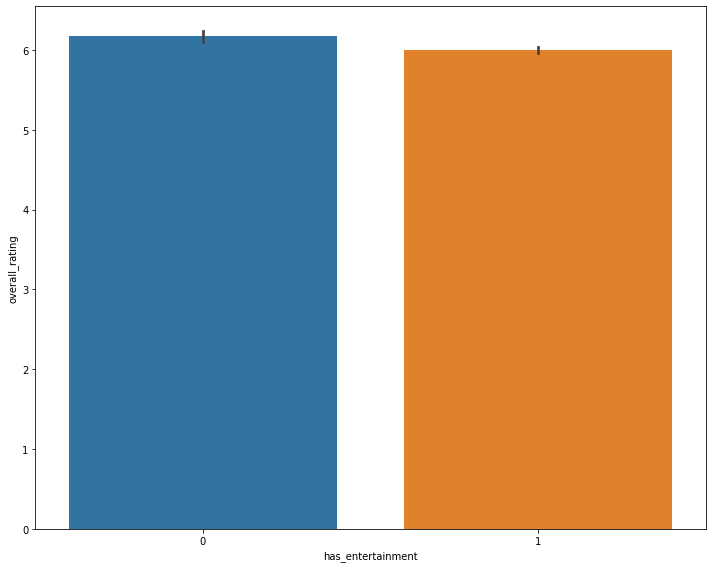

In [17]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x="has_entertainment", y="overall_rating", data=df)
# Having in-flight entertainment does not effect overall rating of the flight by too much.  

[Text(0, 0, 'british-airways'),
 Text(1, 0, 'spirit-airlines'),
 Text(2, 0, 'united-airlines'),
 Text(3, 0, 'air-canada-rouge'),
 Text(4, 0, 'emirates'),
 Text(5, 0, 'american-airlines'),
 Text(6, 0, 'lufthansa'),
 Text(7, 0, 'qantas-airways'),
 Text(8, 0, 'etihad-airways'),
 Text(9, 0, 'jet-airways')]

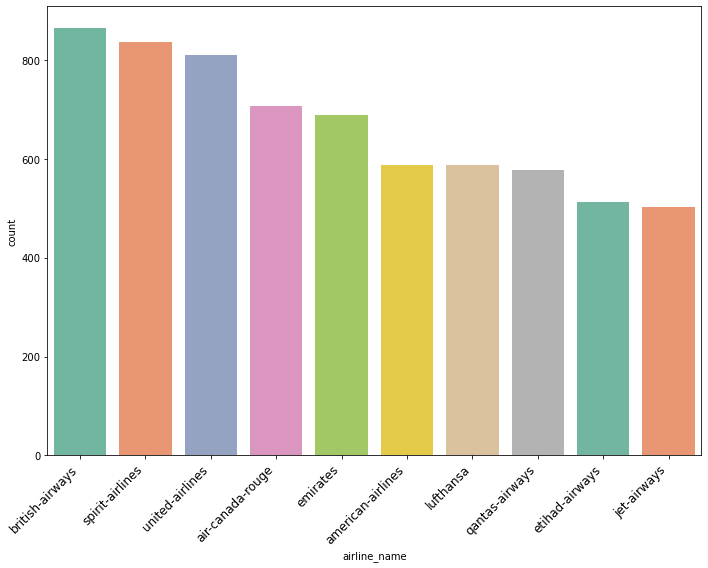

In [18]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="airline_name", data=df[df['has_entertainment'] == 1], order=df['airline_name'][df['has_entertainment'] == 1].value_counts().iloc[:10].index, palette='Set2')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'
)

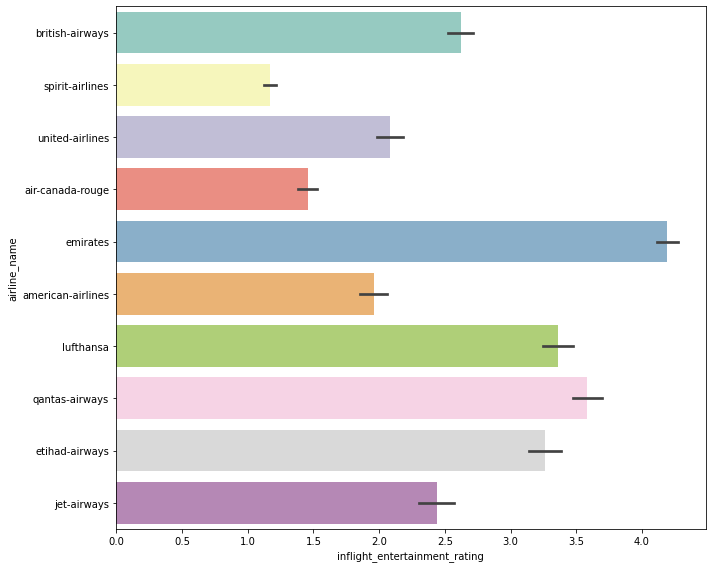

In [19]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x="inflight_entertainment_rating", y="airline_name", data=df[df['has_entertainment'] == 1], order=df['airline_name'][df['has_entertainment'] == 1].value_counts().iloc[:10].index, palette = 'Set3')
# Emirates has the best in-flight entertainment rating followed by Qantas airways and then by Lufthansa.

In [20]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.head()
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# then merge with our data 
merge=pd.merge(world,df,on='CODE')

Text(0.5, 1.0, 'Overall ratings by country')

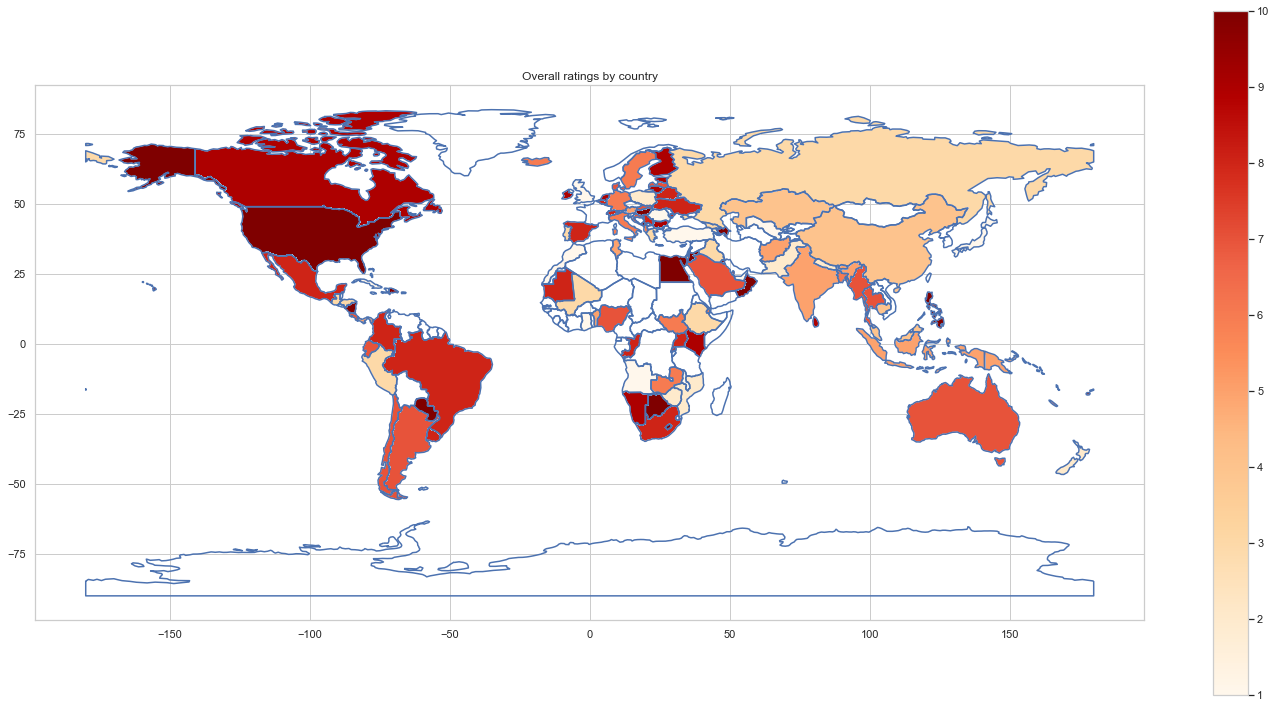

In [44]:
ax = world["geometry"].boundary.plot(figsize=(20,10))
merge.plot(column="overall_rating", ax=ax, cmap='OrRd', legend = True)
ax.set_title("Overall ratings by country")


In [22]:
def plot_grouped_box(df,feat_x,feat_y,filename):
    """
    Plot the distribution of feat_x for different values of feat_y.
    """
    plt.figure(figsize=(6,6))
    sns.set(style="whitegrid")
    ax = sns.catplot(data=df, x=feat_x, y=feat_y, kind='box', palette='Set2')
    ax.set(xlabel=feat_x, ylabel=feat_y)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    return

<Figure size 432x432 with 0 Axes>

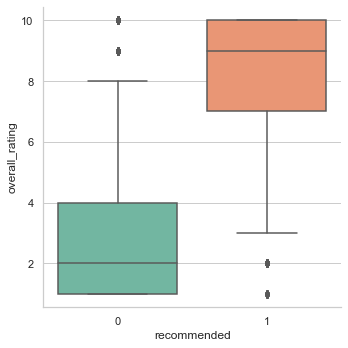

In [23]:
plot_grouped_box(df,"recommended","overall_rating",'./Box-recommend.png')

<Figure size 432x432 with 0 Axes>

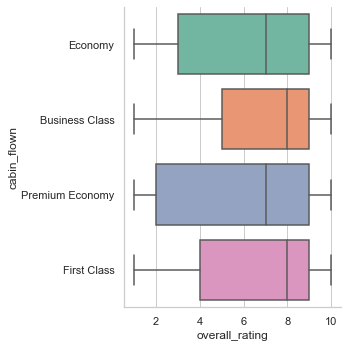

In [24]:
plot_grouped_box(df,"overall_rating","cabin_flown",'./Box-cabin.png')

<Figure size 432x432 with 0 Axes>

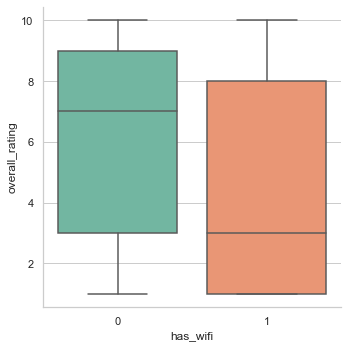

In [25]:
plot_grouped_box(df,"has_wifi","overall_rating",'./Box-wifi.png')

In [26]:
df.isna().sum()

airline_name                         0
author_country                    1591
date                                 0
content                              0
cabin_flown                       2876
overall_rating                    4535
seat_comfort_rating               7690
cabin_staff_rating                7688
food_beverages_rating             8132
inflight_entertainment_rating    10282
wifi_connectivity_rating         40831
value_money_rating                1673
recommended                          0
CODE                                 0
has_wifi                             0
has_entertainment                    0
dtype: int64

In [11]:
df_new = df.drop(['wifi_connectivity_rating', 'inflight_entertainment_rating'], axis = 1)
df_new.shape
df_new.dropna(axis = 0, how = 'any', inplace = True)

In [12]:
df_new.isna().sum()

airline_name             0
author_country           0
date                     0
content                  0
cabin_flown              0
overall_rating           0
seat_comfort_rating      0
cabin_staff_rating       0
food_beverages_rating    0
value_money_rating       0
recommended              0
CODE                     0
has_wifi                 0
has_entertainment        0
dtype: int64

In [14]:
X = df_new.iloc[:,[6,7,8,9,13]]
Y = df_new.iloc[:,10]

In [29]:
X1 = df_new.iloc[:,[6,7,8,12,13]]
Y1 = df_new.iloc[:,9]

In [30]:
X2 = df_new.iloc[:,[6,7,8,12,13]]
Y2 = df_new.iloc[:,5]

In [17]:
X.head()
#Y.head()

,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,value_money_rating,has_entertainment
0,4.0,4.0,4.0,4.0,1
1,4.0,5.0,4.0,5.0,1
2,5.0,5.0,4.0,5.0,1
3,4.0,4.0,3.0,4.0,1
4,4.0,2.0,1.0,2.0,1


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)


In [31]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size=0.30, random_state=42)


In [32]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.30, random_state=42)


In [33]:
X_train2

,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,has_wifi,has_entertainment
2210,1.0,1.0,1.0,0,1
28958,4.0,5.0,3.0,0,1
30117,5.0,4.0,4.0,0,1
2903,5.0,4.0,1.0,0,1
4658,1.0,1.0,1.0,0,1
...,...,...,...,...,...
30559,2.0,2.0,2.0,0,0
7267,4.0,1.0,0.0,0,1
1261,4.0,4.0,3.0,0,1
22318,4.0,3.0,3.0,0,1


In [24]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(X_train,Y_train)

LinearRegression()

In [25]:
LR.predict(X_test)
LR.score(X_test, Y_test)

0.6543014923436887

In [ ]:
LR1 = LinearRegression()
# fitting the training data
LR1.fit(X_train1,Y_train1)

In [34]:
import statsmodels.api as sm    
X_train = sm.add_constant(X_train)
lm_1 = sm.OLS(Y_train,X_train)
lm_2 = lm_1.fit()
lm_2.summary()
#LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            recommended   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     7893.
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        07:32:47   Log-Likelihood:                -3328.9
No. Observations:               20419   AIC:                             6670.
Df Residuals:                   20413   BIC:                             6717.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.4395      0.010    -45.552      0.000      -0.458      -0.421
seat_comfort_rating       0.0529      0.002     24.433      0.000       0.049       0.057
cabin_staff_rating        0.0913      0.002     43.441      0.000       0.087       0.095
food_beverages_rating     0.0176      0.002     10.006      0.000       0.014       0.021
value_money_rating        0.1505      0.002     65.734      0.000       0.146       0.155
has_entertainment        -0.0172      0.008     -2.110      0.035      -0.033      -0.001
==============================================================================
Omnibus:                     1311.463   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5562.802
Skew:                           0.164   Prob(JB):                         0.00
Kurtosis:                       5.536   Cond. No.                         43.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
X_train1 = sm.add_constant(X_train1)
lm_1 = sm.OLS(Y_train1,X_train1)
lm_2 = lm_1.fit()
lm_2.summary()
#LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     value_money_rating   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     7038.
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        07:32:48   Log-Likelihood:                -26133.
No. Observations:               20419   AIC:                         5.228e+04
Df Residuals:                   20413   BIC:                         5.232e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5668      0.029     19.375      0.000       0.510       0.624
seat_comfort_rating       0.4279      0.006     72.575      0.000       0.416       0.439
cabin_staff_rating        0.3707      0.006     63.127      0.000       0.359       0.382
food_beverages_rating     0.1329      0.005     25.103      0.000       0.123       0.143
has_wifi                 -0.2231      0.045     -4.955      0.000      -0.311      -0.135
has_entertainment        -0.2533      0.025    -10.168      0.000      -0.302      -0.204
==============================================================================
Omnibus:                      488.662   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              890.281
Skew:                          -0.189   Prob(JB):                    4.76e-194
Kurtosis:                       3.950   Cond. No.                         45.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
X_train2 = sm.add_constant(X_train2)
lm_1 = sm.OLS(Y_train2,X_train2)
lm_2 = lm_1.fit()
lm_2.summary()
#LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                 1.032e+04
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        07:33:01   Log-Likelihood:                -39953.
No. Observations:               20419   AIC:                         7.992e+04
Df Residuals:                   20413   BIC:                         7.997e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.8391      0.058    -14.577      0.000      -0.952      -0.726
seat_comfort_rating       0.8671      0.012     74.746      0.000       0.844       0.890
cabin_staff_rating        1.0320      0.012     89.311      0.000       1.009       1.055
food_beverages_rating     0.3054      0.010     29.314      0.000       0.285       0.326
has_wifi                 -0.4090      0.089     -4.617      0.000      -0.583      -0.235
has_entertainment        -0.4840      0.049     -9.875      0.000      -0.580      -0.388
==============================================================================
Omnibus:                     2077.021   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16622.447
Skew:                           0.117   Prob(JB):                         0.00
Kurtosis:                       7.414   Cond. No.                         45.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


In [37]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)
RF_pred = clf.predict(X_test)
clf.score(X_test, Y_test)

0.9102959661752943

In [38]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, Y_train)
DT_pred = clf_dt.predict(X_test)
clf_dt.score(X_test,Y_test)

0.9169237801394127

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.4f' % precision_score(Y_test, DT_pred))
print('Recall: %.4f' % recall_score(Y_test, DT_pred))
print('Accuracy: %.4f' % accuracy_score(Y_test, DT_pred))
print('F1 Score: %.4f' % f1_score(Y_test, DT_pred))

Precision: 0.9237
Recall: 0.9396
Accuracy: 0.9169
F1 Score: 0.9316


In [40]:

print('Precision: %.4f' % precision_score(Y_test, RF_pred))
print('Recall: %.4f' % recall_score(Y_test, RF_pred))
print('Accuracy: %.4f' % accuracy_score(Y_test, RF_pred))
print('F1 Score: %.4f' % f1_score(Y_test, RF_pred))

Precision: 0.9275
Recall: 0.9231
Accuracy: 0.9103
F1 Score: 0.9253


In [37]:
reviews_list = df_new['content'].copy()
reviews_list.shape

(29170,)

In [38]:
df_same_review_text = df_new.groupby('content')['content'].count().reset_index(name='n_reviews').sort_values(by='n_reviews',ascending=False)
df_same_review_text[df_same_review_text['n_reviews']>1]

,content,n_reviews
22247,Rating : 10/10 Cabin Flown Economy Value for M...,3
6435,Flew CDG to JFK. Very effective service on the...,2
7553,Flew Sydney - Beijing - London. Both planes we...,2
19014,Manchester to Perth business class. Experience...,2
24489,"TLV-VIE on an A320. Left on time, limited seat...",2
17905,London City-New York JFK via Shannon on A318 b...,2
22251,Rating : 9/10 Cabin Flown Economy Value for Mo...,2
22263,Reading some previous reviews and as a very ne...,2
12347,I flew from Chicago O'Hare to Dublin and from ...,2
6559,Flew Delhi-Chennai-Coimbatore in December with...,2


In [39]:
# No duplicate reviews
df_nlp = df_new.drop_duplicates(subset=['content'], keep = 'first').copy()
df_nlp.shape
# 19 duplicate reviews have been removed

(29151, 14)

In [40]:
reviews_list = df_nlp['content'].copy()
reviews_list.shape

(29151,)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import importlib

In [42]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\warre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\warre\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [43]:
sid = SentimentIntensityAnalyzer()

In [44]:
reviews_polarity = []

for i_review, review in enumerate(reviews_list):
    # print('Review text:')
    # print(review)

    review_polarity_scores = sid.polarity_scores(review)
    review_polarity_score_compound = review_polarity_scores['compound']
    reviews_polarity.append(review_polarity_score_compound)

#print(reviews_polarity)

In [45]:
df_nlp['polarity'] = reviews_polarity
df_nlp.head(50)

,airline_name,author_country,date,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,value_money_rating,recommended,CODE,has_wifi,has_entertainment,polarity
0,adria-airways,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,Economy,7.0,4.0,4.0,4.0,4.0,1,DEU,0,1,0.7351
1,adria-airways,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,Business Class,10.0,4.0,5.0,4.0,5.0,1,USA,0,1,0.8777
2,adria-airways,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,Economy,9.0,5.0,5.0,4.0,5.0,1,CHE,0,1,0.9497
3,adria-airways,Singapore,2014-09-06,Adria serves this 100 min flight from Ljubljan...,Business Class,8.0,4.0,4.0,3.0,4.0,1,SGP,0,1,0.9228
4,adria-airways,Poland,2014-06-16,WAW-SKJ Economy. No free snacks or drinks on t...,Economy,4.0,4.0,2.0,1.0,2.0,0,POL,0,1,0.8184
5,adria-airways,Germany,2014-06-08,Sarajevo-Frankfurt via Ljubljana. I loved flyi...,Economy,9.0,4.0,4.0,3.0,4.0,1,DEU,0,1,0.8827
6,adria-airways,France,2014-06-01,I had flights from Paris to Sarajevo via Ljubl...,Economy,5.0,4.0,4.0,1.0,3.0,1,FRA,0,1,0.7266
7,adria-airways,Slovenia,2014-05-10,LJU to FRA and back both flights were on time....,Economy,9.0,5.0,5.0,4.0,4.0,1,SVN,0,1,0.9571
8,adria-airways,Singapore,2014-01-13,On my Ljubljana - Munich flight in business cl...,Business Class,8.0,4.0,3.0,4.0,4.0,1,SGP,0,1,0.8674
9,adria-airways,Slovenia,2014-01-06,Flights from LJU to ZRH and back all on time. ...,Economy,10.0,5.0,5.0,4.0,4.0,1,SVN,0,1,0.9677


In [46]:
# Stop words.
# Airlines appearing in the dataset. This is the official name of the airlines. These words should be removed from the review text.
airlines_lower = df_nlp['airline_name'].str.lower().unique().tolist()
# Words appearing in the official name of the airlines. These words should be removed from the review text.
airlines_identifier = ['airlines',
                       'air lines',
                       'airline',
                       'air line',
                       'airways',
                       'air']
# In addition to the official name of the airlines, customers can use shortened versions of this name.
airlines_informal_lower = []
for airline in airlines_lower:
    found = False
    for airline_identifier in airlines_identifier:
        if found == False:
            if str(' '+airline_identifier) in airline:
                airline_informal = airline.replace(str(' '+airline_identifier),'')
                airlines_informal_lower.append(airline_informal)
                found = True
# Other stop words.
additional_stopwords = ['one','get','also','however','even','make', 'flight','available', 'wizzair', 'lpl', 'lju', 'fra', 'zrh']

nltk_stopwords = stopwords.words('english')
all_stopwords = nltk_stopwords + airlines_lower + airlines_identifier + airlines_informal_lower + additional_stopwords

In [47]:
from nltk.corpus import wordnet
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = all_stopwords
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df_nlp["review_clean"] = df_nlp["content"].apply(lambda x: clean_text(x))

In [55]:
positive_reviews = df_nlp[df_nlp['recommended']==1]
negative_reviews = df_nlp[df_nlp['recommended']==0]

In [56]:
positive_reviews.head()

,airline_name,author_country,date,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,value_money_rating,recommended,CODE,has_wifi,has_entertainment,polarity,review_clean
0,adria-airways,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,Economy,7.0,4.0,4.0,4.0,4.0,1,DEU,0,1,0.7351,outbound fra/prn hour min thought drinks/snack...
1,adria-airways,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,Business Class,10.0,4.0,5.0,4.0,5.0,1,USA,0,1,0.8777,two short hop zrh-lju lju-vie fast crj seat co...
2,adria-airways,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,Economy,9.0,5.0,5.0,4.0,5.0,1,CHE,0,1,0.9497,flew zurich-ljubljana newish almost full depar...
3,adria-airways,Singapore,2014-09-06,Adria serves this 100 min flight from Ljubljan...,Business Class,8.0,4.0,4.0,3.0,4.0,1,SGP,0,1,0.9228,adria serve min ljubljana amsterdam brand new ...
5,adria-airways,Germany,2014-06-08,Sarajevo-Frankfurt via Ljubljana. I loved flyi...,Economy,9.0,4.0,4.0,3.0,4.0,1,DEU,0,1,0.8827,sarajevo-frankfurt via ljubljana love fly smal...


In [57]:
df_nlp.iloc[4]

airline_name                                                 adria-airways
author_country                                                      Poland
date                                                            2014-06-16
content                  WAW-SKJ Economy. No free snacks or drinks on t...
cabin_flown                                                        Economy
overall_rating                                                           4
seat_comfort_rating                                                      4
cabin_staff_rating                                                       2
food_beverages_rating                                                    1
value_money_rating                                                       2
recommended                                                              0
CODE                                                                   POL
has_wifi                                                                 0
has_entertainment        

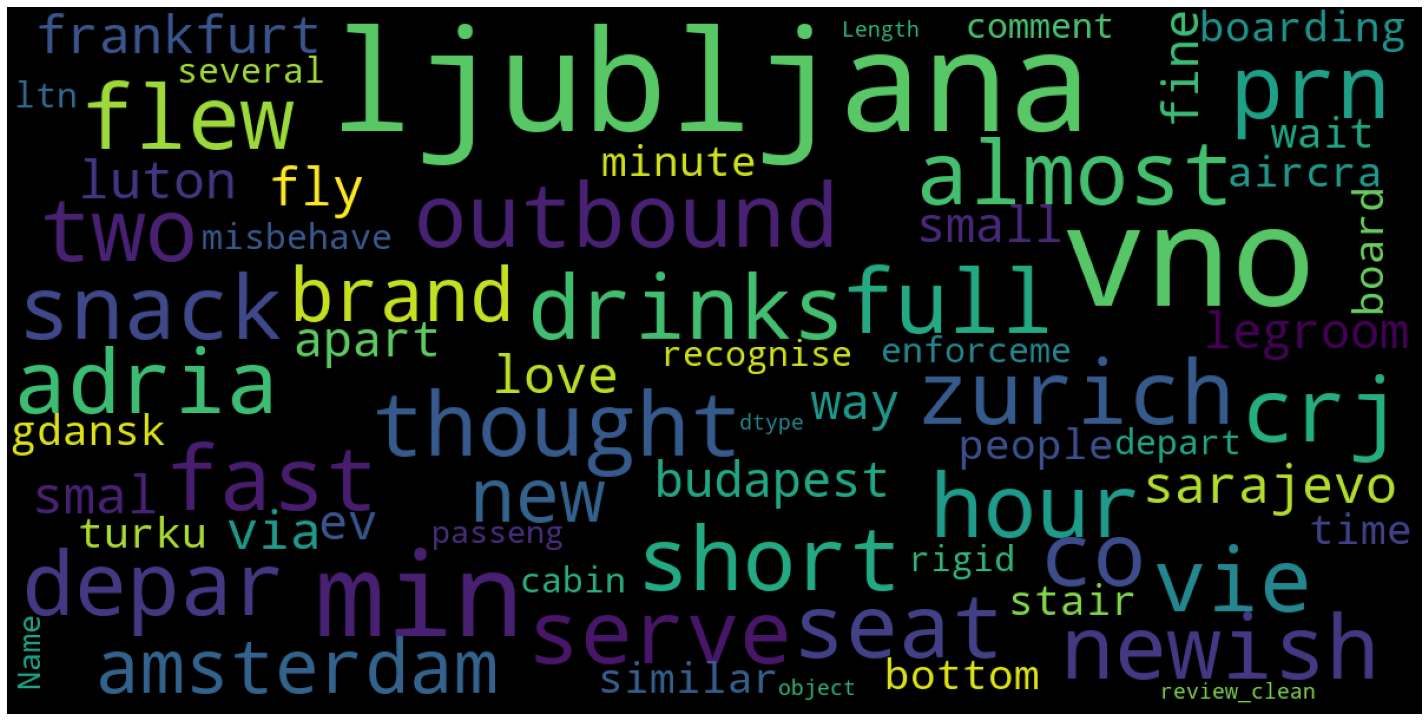

In [60]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        stopwords = all_stopwords,
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(positive_reviews['review_clean'])

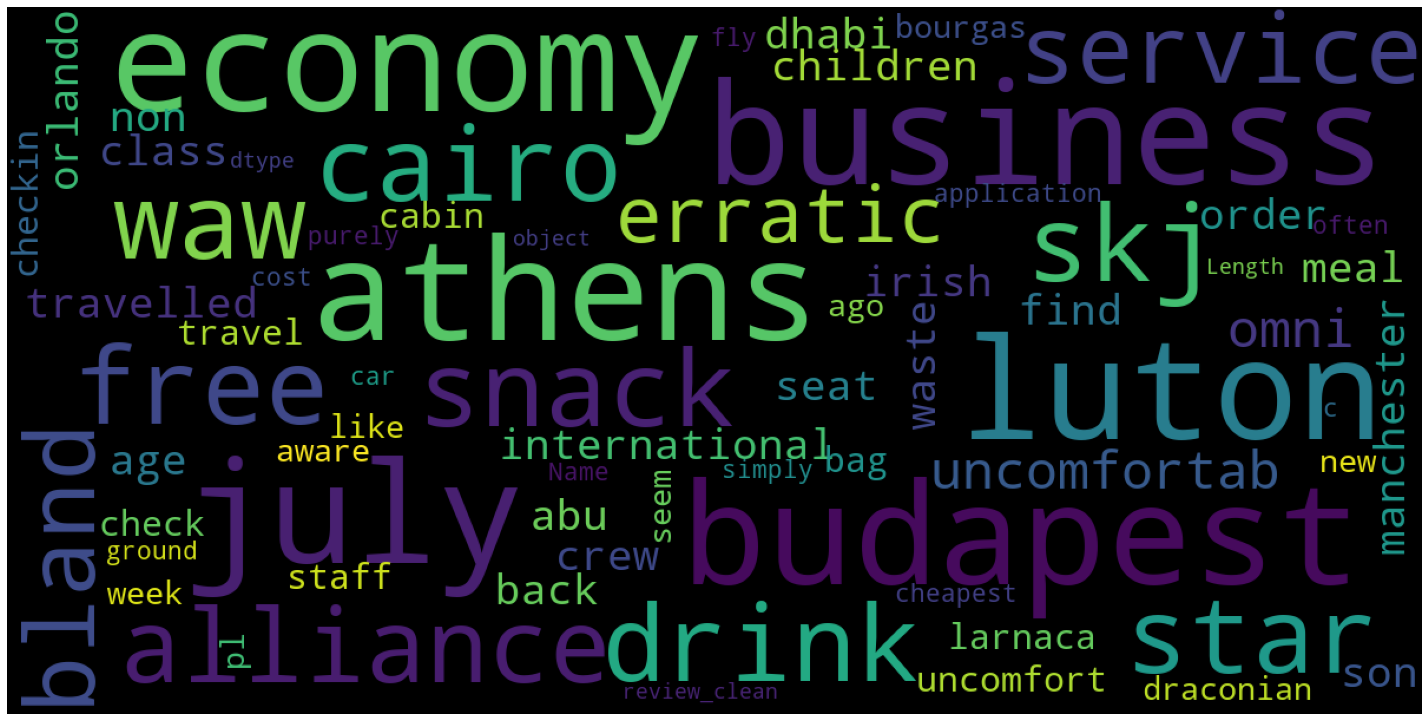

In [61]:
show_wordcloud(negative_reviews['review_clean'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df_nlp["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df_nlp.index
df_nlp = pd.concat([df_nlp, tfidf_df], axis=1)

In [ ]:
df_nlp.head()

In [ ]:
corr_values = df_nlp[['polarity','recommended']].dropna(axis=0,how='any').corr()

In [ ]:
def plot_cmap(matrix_values, figsize_w, figsize_h, filename):
    if figsize_w is not None and figsize_h is not None:
        plt.figure(figsize=(figsize_w,figsize_h))
    else:
        plt.figure()
    cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
    sns.heatmap(matrix_values, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1)
    plt.savefig(filename)
    plt.show()
    return cmap

plot_cmap(matrix_values=corr_values, 
          figsize_w=4, 
          figsize_h=4,
          filename='./Corr1.png')

In [ ]:
def get_pos_neu_neg_review_score(df_row):
    pos_neu_neg_review_score = None
    if (df_row['overall_rating'] is None or str(df_row['overall_rating']) == '<NA>'):
        pos_neu_neg_review_score = None
    else:
        if (df_row['overall_rating'] <= 4):
            pos_neu_neg_review_score = 'neg'
        elif (df_row['overall_rating'] > 4 and df_row['overall_rating'] <= 6):
            pos_neu_neg_review_score = 'neu'
        else:
            pos_neu_neg_review_score = 'pos'
    return pos_neu_neg_review_score

In [ ]:
df_nlp['pos_neu_neg_review_score'] = df_nlp.apply(lambda x: get_pos_neu_neg_review_score(x),axis=1)
df_nlp[['content','pos_neu_neg_review_score']].head(5)

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [5, 7]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

#df = pd.DataFrame({'numbers': [2, 4, 1, 4, 3, 2, 1, 3, 2, 4]})
df_nlp['pos_neu_neg_review_score'].value_counts().plot(ax=ax, kind='bar', ylabel='frequency')

plt.show()

In [ ]:
df_nlp = pd.get_dummies(df_nlp,columns= ['pos_neu_neg_review_score'])

In [ ]:
df_nlp.head(5)

In [ ]:
X = df_nlp.iloc[:,[6,7,8,9,13,14,15,16,17]]
Y = df_nlp.iloc[:,10]
#X.head()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)


In [ ]:
X_train

In [ ]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(X_train,Y_train)

In [ ]:
LR.predict(X_test)
LR.score(X_test, Y_test)

In [ ]:
import statsmodels.api as sm    
X_train1 = sm.add_constant(X_train)
lm_1 = sm.OLS(Y_train,X_train1)
lm_2 = lm_1.fit()
lm_2.summary()
#LR.summary()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

In [ ]:
Y_pred = clf.predict(X_test)
clf.score(X_test, Y_test)

In [48]:
review_words = list(df_nlp["review_clean"])
# remove stop words

print(review_words[:1][0][:30])

outbound fra/prn hour min thou


In [56]:
tokens = [d.split() for d in review_words]

In [57]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(review_words)
# Create Corpus
texts = review_words
# Term Document Frequency
#corpus = [id2word.doc2bow(text) for text in texts]
# View
#print(corpus[:1][0][:30])
print(texts)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string